<a href="https://colab.research.google.com/github/DARSHITA2804/DEEPLEARNING/blob/main/lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib numpy


Epoch 1: Avg loss 162.2229
Epoch 2: Avg loss 124.9240
Epoch 3: Avg loss 119.5600
Epoch 4: Avg loss 116.8461
Epoch 5: Avg loss 115.1469
Epoch 6: Avg loss 113.9818
Epoch 7: Avg loss 113.0682
Epoch 8: Avg loss 112.2899
Epoch 9: Avg loss 111.6539
Epoch 10: Avg loss 111.1155


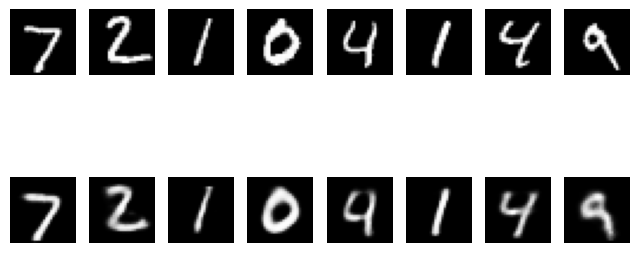

In [ ]:
 import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Config ---
batch_size = 128
epochs = 10
lr = 1e-3
latent_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data ---
transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST("data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST("data", train=False, download=True, transform=transform),
    batch_size=batch_size, shuffle=False
)

# --- Model ---
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, z_dim)   # μ
        self.fc22 = nn.Linear(400, z_dim)   # logσ²
        self.fc3 = nn.Linear(z_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# --- Training ---
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device).view(-1, 784)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}: Avg loss {train_loss / len(train_loader.dataset):.4f}")

# --- Run training ---
for epoch in range(1, epochs+1):
    train(epoch)

# --- Visualize ---
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device).view(-1, 784)
    recon, _, _ = model(data)
    n = 8
    comparison = torch.cat([data[:n], recon[:n]])
    comparison = comparison.cpu().view(-1, 1, 28, 28)
    grid = torch.cat([comparison[:n], comparison[n:]])
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(data[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()


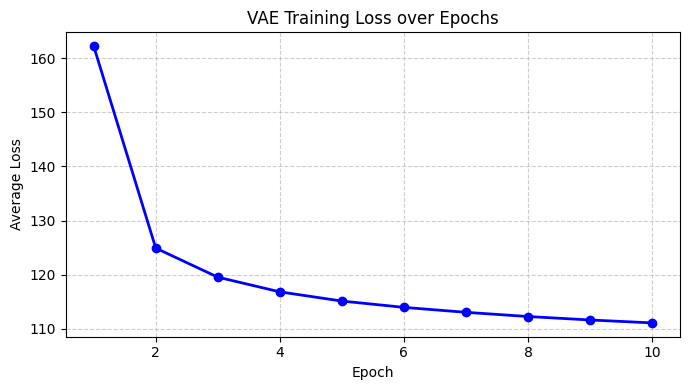

In [ ]:
i
